# Classic ML -- SVM 

## 0. Install necessary libraries

In [37]:
# Basic data analysis libraries 
import numpy as np
import pandas as pd

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing and cleaning
import emoji 
from emoji import demojize, emojize

# NLP Libraries
import nltk
import spacy
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords # I dont want to use this one for now
from nltk.tokenize import word_tokenize
from spacy.lang.en import English

# Sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

## 1. Load data

In [38]:
# Read the data from the tsv file
def load_data(train_path, dev_path, text_path):
    train_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/train.tsv', sep='\t')
    dev_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/dev.tsv', sep='\t')
    test_df = pd.read_csv('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/test.tsv', sep = '\t') 

    # Split the data into features and labels
    X_train = train_df.iloc[:, 0] # The first column is the tweets
    y_train = train_df.iloc[:, 1] # The second column is the labels

    # Follow the same steps for the dev set
    X_dev = dev_df.iloc[:, 0]
    y_dev = dev_df.iloc[:, 1]

    # Follow the same steps for the test set
    X_test = test_df.iloc[:, 0]
    y_test = test_df.iloc[:, 1]

    # Map the labels to integers
    label_map = {'OFF': 1, 'NOT': 0} # is this step necessary?
    y_train = y_train.map(label_map)
    y_dev = y_dev.map(label_map)
    y_test = y_test.map(label_map)

    return (X_train, y_train), (X_dev, y_dev), (X_test, y_test)

In [39]:
# Save the labels fro classification report
class_names = ['Offensive', 'Not Offensive']

## 2. Build model

In [40]:
def create_basic_svm(max_features=10000, ngram_range=(1, 1)):
    """
    Create a basic SVM model using the CountVectorizer and LinearSVC
    """
    # Create a pipeline
    pipeline = Pipeline([
        # Will add feature extraction and classification steps here
        ('vectorizer', CountVectorizer(
            lowercase=True, # Remember to turn if off for testing
            max_features=max_features, # May need to change it for testing 
            ngram_range=ngram_range, # Consider incleasing it for testing
            strip_accents='unicode' # Can it manage emojis?
            )),
        # Dont forget to try tf-idf
        ('classifier', LinearSVC())
    ])
    return pipeline

In [41]:
# Train the model
def train_model(pipeline, X_train, y_train):
    """
    Train the model
    """
    pipeline.fit(X_train, y_train)
    return pipeline


## 3. Train & Evaluate

In [49]:
def evalute_model(pipeline, X, y, split_name=""): # Why?
    """
    Evaluate the model
    """
    # Get predictions
    y_pred = pipeline.predict(X)
    
    # Calculate metrics
    acc = accuracy_score(y, y_pred)
    class_report = classification_report(y, y_pred, output_dict= True, target_names=class_names)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Print results 
    print(f"\nResults for {split_name} set:")
    print(f'Accuracy: {acc: .4f}')
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {split_name} set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return {
        "Accuracy": acc,
        "Classification Report": class_report,
        'Confusion Matrix': conf_matrix,
        'Predictions': y_pred
    }


## 4. Main execution

/Users/hongxuzhou/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Results for Train set:
Accuracy:  0.9826

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8192
           1       0.99      0.96      0.97      4047

    accuracy                           0.98     12239
   macro avg       0.98      0.98      0.98     12239
weighted avg       0.98      0.98      0.98     12239



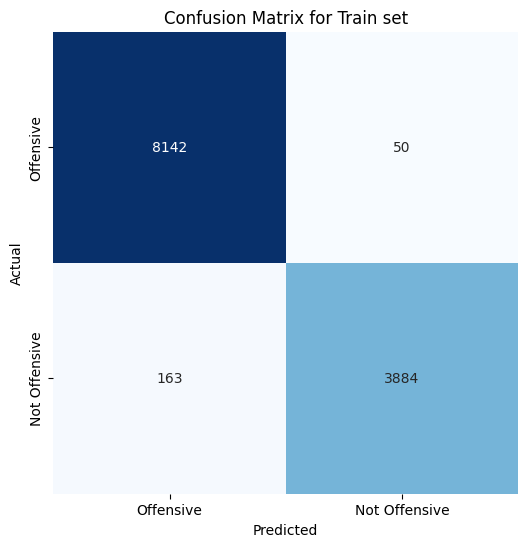


Results for Dev set:
Accuracy:  0.7267

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       647
           1       0.63      0.54      0.58       352

    accuracy                           0.73       999
   macro avg       0.70      0.68      0.69       999
weighted avg       0.72      0.73      0.72       999



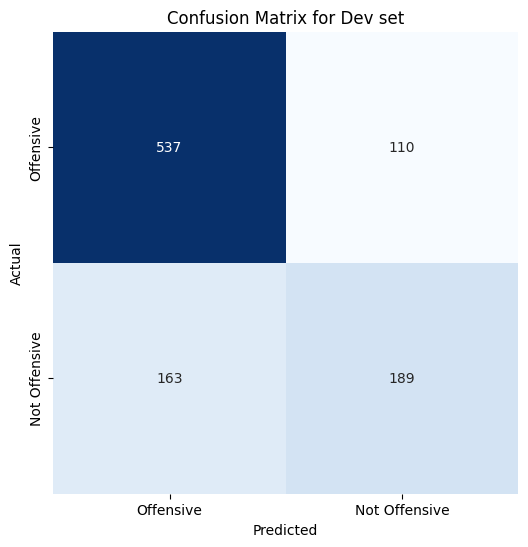

In [50]:
if __name__ == '__main__':
    # 1. Load the data
    (X_train, y_train), (X_dev, y_dev), (X_test, y_test) = load_data('/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/train.tsv', 
                                                                     '/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/dev.tsv', 
                                                                     '/Users/hongxuzhou/LfD/LfD_final_Assignment/data_sets/test.tsv'
                                                                     )
    
    # 2. Create and train the pipeline 
    pipeline = create_basic_svm(
        max_features=100000, # May need to change it for testing
        ngram_range=(1, 1) # Consider incleasing it for testing
    )
    
    pipeline = train_model(pipeline, X_train, y_train)
    
    # 3. Evaluate the model
    train_results = evalute_model(pipeline, X_train, y_train, "Train")
    dev_results = evalute_model(pipeline, X_dev, y_dev, "Dev")
    #test_results = evalute_model(pipeline, X_test, y_test, "Test") # We dont run it for now
    
    # 4. 